In [ ]:
import sys
!{sys.executable} -m pip install numpy opencv-python matplotlib scikit-learn tensorflow pillow

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [4]:
def preprocess_image_with_edges(img):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    edges = cv2.Canny(gray, 100, 200)
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    normalized = cv2.normalize(blurred, None, 0, 255, cv2.NORM_MINMAX)
    resized = cv2.resize(normalized, (128, 128))
    expanded = np.expand_dims(resized, axis=-1)
    return expanded

def load_and_preprocess_data(dataset_path):
    images = []
    labels = []
    
    # Define subfolder paths
    pothole_dir = os.path.join(dataset_path, 'potholes')
    normal_dir = os.path.join(dataset_path, 'normal')
    
    # Load pothole images (label = 1)
    if os.path.exists(pothole_dir):
        for img_name in os.listdir(pothole_dir):
            if img_name.endswith('.jpg'):  # Filter for .jpg files
                img_path = os.path.join(pothole_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    processed_img = preprocess_image_with_edges(img)
                    images.append(processed_img)
                    labels.append(1)  # Pothole
    
    # Load normal images (label = 0)
    if os.path.exists(normal_dir):
        for img_name in os.listdir(normal_dir):
            if img_name.endswith('.jpg'):  # Filter for .jpg files
                img_path = os.path.join(normal_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    processed_img = preprocess_image_with_edges(img)
                    images.append(processed_img)
                    labels.append(0)  # No pothole
    
    return np.array(images), np.array(labels)

In [5]:
def create_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),  # Added dropout for regularization
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
def train_model(model, X_train, y_train, X_test, y_test):
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    
    # Compute class weights for balanced training using scikit-learn
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.001)
    
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        validation_data=(X_test, y_test),
        epochs=50,
        callbacks=[early_stopping],
        class_weight=class_weight_dict  # Use class weights
    )
    return history

In [7]:
def detect_potholes_realtime(model):
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        processed_frame = preprocess_image_with_edges(frame)
        input_frame = processed_frame.reshape(1, 128, 128, 1) / 255.0
        prediction = model.predict(input_frame)
        original_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if prediction[0][0] > 0.5:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 100, 200)
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)
                cv2.rectangle(original_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                width_cm = w  # Adjust this scaling factor based on your camera and real-world distance
                height_cm = h  # Adjust this scaling factor based on your camera and real-world distance
                text = f'Pothole: {width_cm}cm x {height_cm}cm'
                cv2.putText(original_frame, text, (x, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            else:
                cv2.putText(original_frame, 'Pothole Detected', (50, 50),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        else:
            cv2.putText(original_frame, 'No Pothole', (50, 50),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow('Pothole Detection', cv2.cvtColor(original_frame, cv2.COLOR_RGB2BGR))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Fold 1
Epoch 1/50


c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5554 - loss: 0.6763 - val_accuracy: 0.7353 - val_loss: 0.5268
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7606 - loss: 0.5256 - val_accuracy: 0.7647 - val_loss: 0.4878
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7544 - loss: 0.5320 - val_accuracy: 0.7941 - val_loss: 0.4477
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7592 - loss: 0.5233 - val_accuracy: 0.7868 - val_loss: 0.4456
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7012 - loss: 0.5519 - val_accuracy: 0.8162 - val_loss: 0.4150
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7475 - loss: 0.5254 - val_accuracy: 0.8162 - val_loss: 0.3977
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7804 - loss: 0.4741 - val_accuracy: 0.8088 - val_loss: 0.4044
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7645 - loss: 0.5063 - val_accuracy: 0.8088 - val_loss: 0.

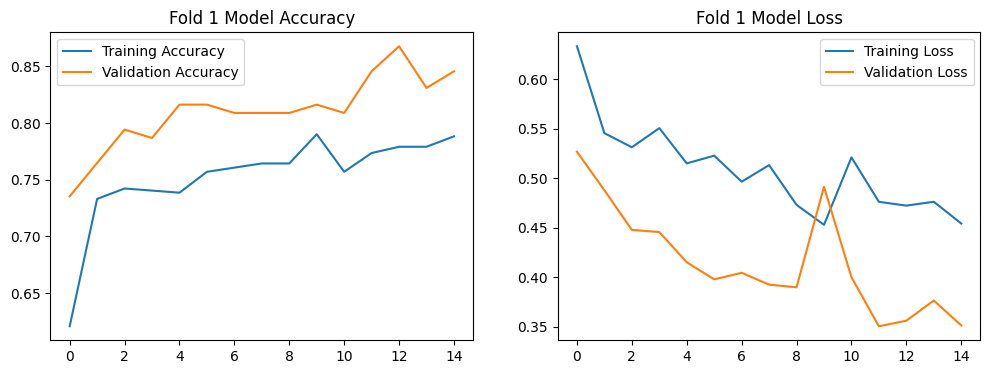

Fold 2
Epoch 1/50


c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5996 - loss: 0.6806 - val_accuracy: 0.7794 - val_loss: 0.4858
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6960 - loss: 0.5590 - val_accuracy: 0.8162 - val_loss: 0.4449
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7081 - loss: 0.5752 - val_accuracy: 0.8088 - val_loss: 0.4127
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7612 - loss: 0.4913 - val_accuracy: 0.8088 - val_loss: 0.3714
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7337 - loss: 0.5442 - val_accuracy: 0.8382 - val_loss: 0.3572
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7588 - loss: 0.4872 - val_accuracy: 0.8162 - val_loss: 0.3850
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7521 - loss: 0.4993 - val_accuracy: 0.8162 - val_loss: 0.3693
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7586 - loss: 0.4837 - val_accuracy: 0.7941 - val_loss: 0.

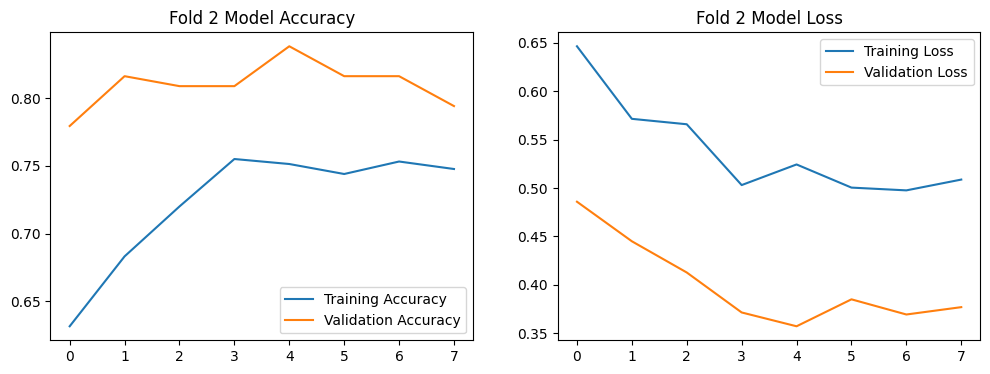

Fold 3
Epoch 1/50


c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5068 - loss: 0.8350 - val_accuracy: 0.7647 - val_loss: 0.5900
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6965 - loss: 0.6029 - val_accuracy: 0.6691 - val_loss: 0.6051
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7297 - loss: 0.5551 - val_accuracy: 0.7647 - val_loss: 0.5218
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7390 - loss: 0.5376 - val_accuracy: 0.7426 - val_loss: 0.5283
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7631 - loss: 0.5264 - val_accuracy: 0.7794 - val_loss: 0.4917
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7464 - loss: 0.5173 - val_accuracy: 0.7426 - val_loss: 0.4889
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7309 - loss: 0.5282 - val_accuracy: 0.7647 - val_loss: 0.4850
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7623 - loss: 0.5069 - val_accuracy: 0.7794 - val_loss: 0.

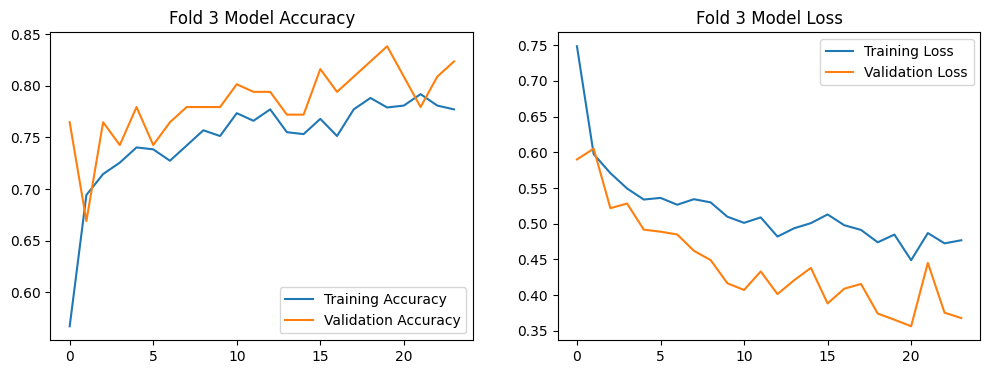

Fold 4
Epoch 1/50


c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5654 - loss: 0.6775 - val_accuracy: 0.7132 - val_loss: 0.5455
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7543 - loss: 0.5501 - val_accuracy: 0.6765 - val_loss: 0.5986
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7115 - loss: 0.5390 - val_accuracy: 0.7353 - val_loss: 0.5284
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7511 - loss: 0.5293 - val_accuracy: 0.7206 - val_loss: 0.5333
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7740 - loss: 0.4879 - val_accuracy: 0.7868 - val_loss: 0.4806
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7675 - loss: 0.4913 - val_accuracy: 0.8015 - val_loss: 0.4709
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7795 - loss: 0.4887 - val_accuracy: 0.7574 - val_loss: 0.5133
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7633 - loss: 0.4833 - val_accuracy: 0.7794 - val_loss: 0.

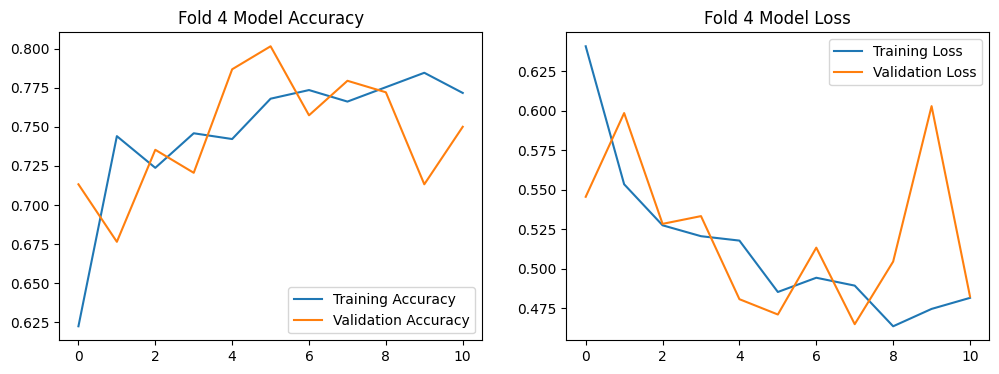

Fold 5
Epoch 1/50


c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5697 - loss: 0.7097 - val_accuracy: 0.7333 - val_loss: 0.5086
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7469 - loss: 0.5532 - val_accuracy: 0.7481 - val_loss: 0.4804
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7413 - loss: 0.5370 - val_accuracy: 0.7407 - val_loss: 0.5368
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7729 - loss: 0.5038 - val_accuracy: 0.7259 - val_loss: 0.5877
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7812 - loss: 0.4879 - val_accuracy: 0.7333 - val_loss: 0.5427
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7602 - loss: 0.4688
Fold 5 Test Accuracy: 74.81%


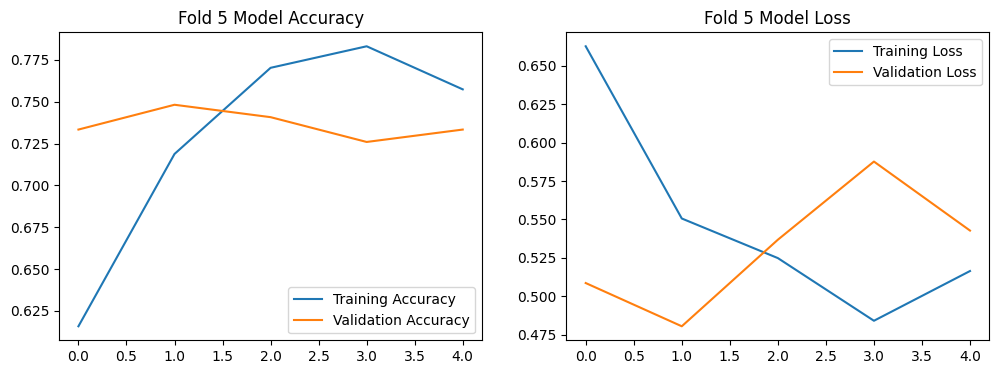

Average Test Accuracy: 80.40%
Epoch 1/50


c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\Documents\GitHub\Sem_4\Robotics-MFC-S4-D12\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.6171 - loss: 0.6616 - val_accuracy: 0.7511 - val_loss: 0.5021
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7138 - loss: 0.5768 - val_accuracy: 0.7629 - val_loss: 0.4728
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7591 - loss: 0.5252 - val_accuracy: 0.7393 - val_loss: 0.5086
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7423 - loss: 0.5597 - val_accuracy: 0.7644 - val_loss: 0.4703
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7819 - loss: 0.4850 - val_accuracy: 0.7732 - val_loss: 0.4590
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7810 - loss: 0.5208 - val_accuracy: 0.7923 - val_loss: 0.4292
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7600 - loss: 0.5172 - val_accuracy: 0.7894 - val_loss: 0.4308
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7676 - loss: 0.4907 - val_accuracy: 0.7968 - val_loss: 0.

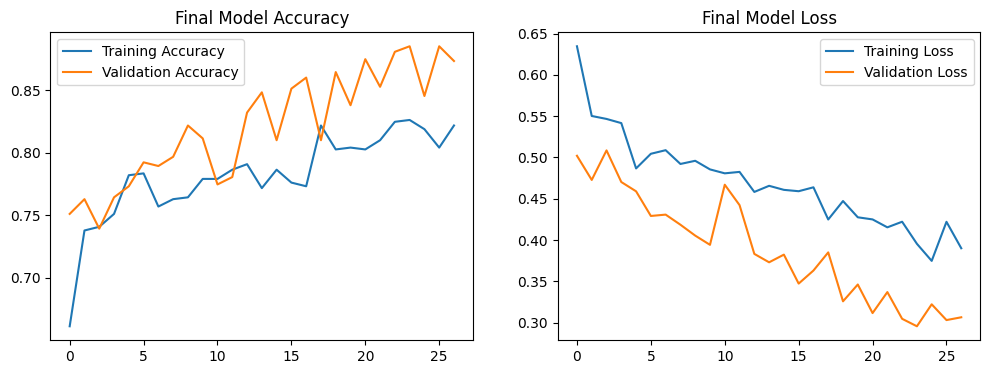

In [8]:
# Load and preprocess data
dataset_path = 'pothole_image_data'
X, y = load_and_preprocess_data(dataset_path)
X = X / 255.0

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
accuracies = []

for train_index, test_index in kfold.split(X):
    print(f'Fold {fold}')
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train model
    model = create_model()
    history = train_model(model, X_train, y_train, X_test, y_test)
    
    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Fold {fold} Test Accuracy: {accuracy * 100:.2f}%")
    accuracies.append(accuracy)
    
    # Plot training history for this fold
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold} Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold} Model Loss')
    plt.legend()
    plt.show()
    
    fold += 1

# Print average accuracy across folds
print(f'Average Test Accuracy: {np.mean(accuracies) * 100:.2f}%')

# Use the last trained model for real-time detection (or train one final model on all data)
final_model = create_model()
final_history = train_model(final_model, X, y, X, y)  # Train on all data for deployment

# Evaluate final model (optional, since we used cross-validation)
loss, accuracy = final_model.evaluate(X, y)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")

# Plot final training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Final Model Loss')
plt.legend()
plt.show()

In [ ]:
# Start real-time detection with the final model
detect_potholes_realtime(final_model)